In [1]:
import argparse
from pathlib import Path, PurePath, PurePosixPath
import metadata_completion.utilities as ut
import torchaudio
from collections import defaultdict
import progressbar
import os
import json
import plot

In [28]:
def create_speaker_dependent_splits(list_metadata, audio_extension, librispeech_splits,
        val_hours=1, test_hours=1):

    speakerTalk = {}
    nData = len(list_metadata)

    bar = progressbar.ProgressBar(maxval=nData)
    bar.start()

    speaker_splits = defaultdict(lambda :{
        "train": [],
        "val": [],
        "test":[],
        "speaker_independent": [],
        "librispeech_train_speakers": []
        })

    for index, pathMetadata in enumerate(list_metadata):
        bar.update(index)
        with open(pathMetadata, 'rb') as file:
            locMetadata = json.load(file)

        speaker_name = locMetadata['speaker']

        path_audio_data = os.path.splitext(pathMetadata)[0] + audio_extension

        info = torchaudio.info(path_audio_data)
        totAudio = info.num_frames / (info.sample_rate * 3600.)

        if speaker_name is None:
            speaker_name = 'null'

        if speaker_name not in speakerTalk:
            speakerTalk[speaker_name] = 0

        speakerTalk[speaker_name] += totAudio

        time_so_far = speakerTalk[speaker_name]
        splits = speaker_splits[speaker_name]

        assert(speaker_name not in librispeech_splits["dev"])
        assert(speaker_name not in librispeech_splits["test"])

        # import pdb; pdb.set_trace()
        if (int(speaker_name) in librispeech_splits["train"]):
            splits["librispeech_train_speakers"].append(path_audio_data)
            # print("Found speaker in librispeech train")
        else:
            if time_so_far < test_hours:
                splits["test"].append(path_audio_data)
            elif time_so_far < (val_hours + test_hours):
                splits["val"].append(path_audio_data)
            else:
                splits["train"].append(path_audio_data)

    for speaker_id, splits in speaker_splits.items():
        if len(splits["train"]) == 0 and speaker_id not in librispeech_splits["train"]:
            splits["speaker_independent"].extend(splits["val"])
            splits["speaker_independent"].extend(splits["test"])
            splits["val"] = []
            splits["test"] = []
            # print("Not enough val and test data!")

    for speaker_id, splits in speaker_splits.items():
        if(len(splits["librispeech_train_speakers"]) > 0):
            assert(len(splits["speaker_independent"]) == 0)
            assert(len(splits["train"]) == 0)
            assert(len(splits["val"]) == 0)
            assert(len(splits["test"]) == 0)
        elif(len(splits["speaker_independent"]) > 0):
            assert(len(splits["train"]) == 0)
            assert(len(splits["val"]) == 0)
            assert(len(splits["test"]) == 0)
        else:
            print(f'Speaker dependent split for speaker: ${speaker_id} with total hours: ${speakerTalk[speaker_id]}')

    bar.finish()
    return speaker_splits, speakerTalk

In [6]:
librilight_path = "/checkpoint/padentomasello/libri-light/large/"


In [8]:
list_metadata =  ut.get_all_metadata(librilight_path, ".json")

In [29]:
with open("speakers.json") as f:
    librispeech_splits = json.load(f)
speaker_splits, speaker_times = create_speaker_dependent_splits(list_metadata, ".flac", librispeech_splits)

100% (197714 of 197714) |################| Elapsed Time: 0:03:11 Time:  0:03:11


Speaker dependent split for speaker: $4663 with total hours: $9.337251909722225
Speaker dependent split for speaker: $695 with total hours: $5.799672986111112
Speaker dependent split for speaker: $7590 with total hours: $2.706520572916667
Speaker dependent split for speaker: $1044 with total hours: $2.8739974479166657
Speaker dependent split for speaker: $7171 with total hours: $11.836330052083333
Speaker dependent split for speaker: $1388 with total hours: $2.7325393749999995
Speaker dependent split for speaker: $286 with total hours: $7.935957951388889
Speaker dependent split for speaker: $4815 with total hours: $3.1434077777777776
Speaker dependent split for speaker: $5421 with total hours: $2.3634559027777775
Speaker dependent split for speaker: $3517 with total hours: $2.656784444444445
Speaker dependent split for speaker: $7853 with total hours: $4.500851475694444
Speaker dependent split for speaker: $5943 with total hours: $2.181196232638889
Speaker dependent split for speaker: 

In [10]:
len(speaker_splits)

6875

In [15]:
librispeech_speakers = len([x for x, split in speaker_splits.items() if split["librispeech_train_speakers"] ])
speaker_independent = len([x for x, split in speaker_splits.items() if split["speaker_independent"] ])
personalization = len([x for x, split in speaker_splits.items() if split["val"]])

In [20]:
labels = ["Speakers in Librispeech Train", "Less than 2 hours of data", "Speaker Dependent Set"]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

(-1.1131188209745688,
 1.1006247205860449,
 -1.1035603853925453,
 1.11313809021167)

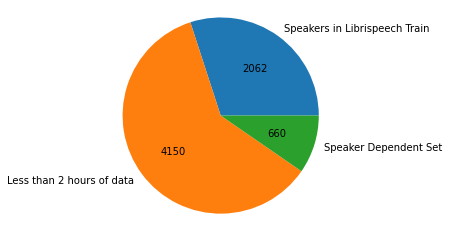

In [27]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
fig, ax = plt.subplots()
values = [librispeech_speakers, speaker_independent, personalization]
ax.pie(values, labels=labels, autopct=autopct_format(values))
ax.axis('equal')

In [31]:
personalization_speakers = [ x for x, split in speaker_splits.items() if split["val"]]

In [33]:
len(personalization_speakers)

660

/private/home/padentomasello/.conda/envs/libri-light-base/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


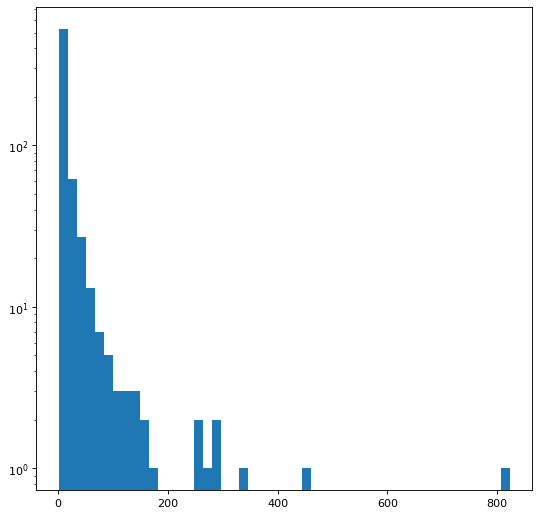

In [52]:
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)
n_bins = 50
plt.hist([speaker_times[id] for id in personalization_speakers], n_bins)
plt.yscale('log', nonposy='clip')
#plt.xscale('log', nonposx='clip')

/private/home/padentomasello/.conda/envs/libri-light-base/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


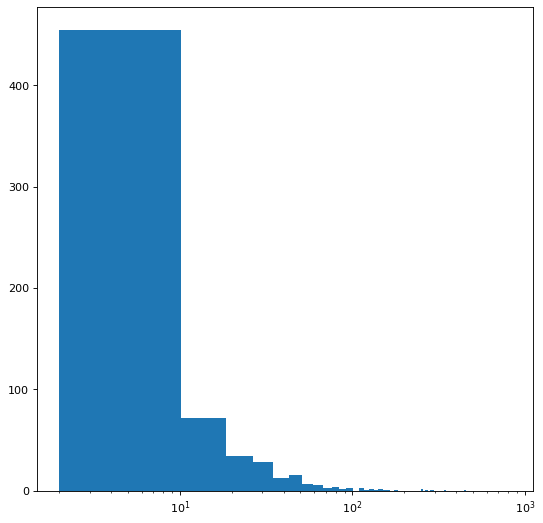

In [55]:
n_bins = 100
figure(figsize=(8, 8), dpi=80)
plt.hist([speaker_times[id] for id in personalization_speakers], n_bins)
plt.xscale('log', nonposx='clip')

/private/home/padentomasello/.conda/envs/libri-light-base/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.
/private/home/padentomasello/.conda/envs/libri-light-base/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


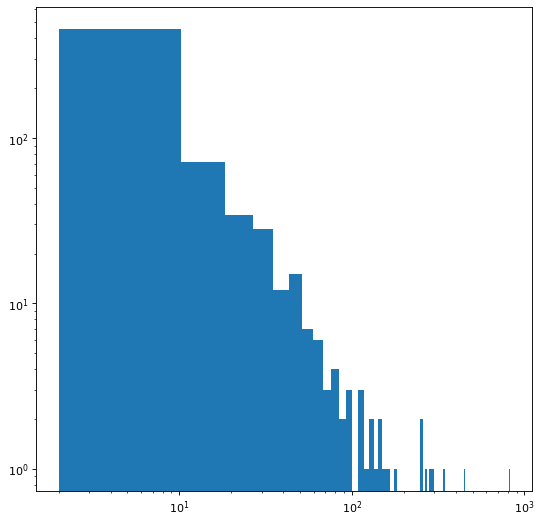

In [56]:
n_bins = 100
figure(figsize=(8, 8), dpi=80)
plt.hist([speaker_times[id] for id in personalization_speakers], n_bins)
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')

## > 10 Hours


211


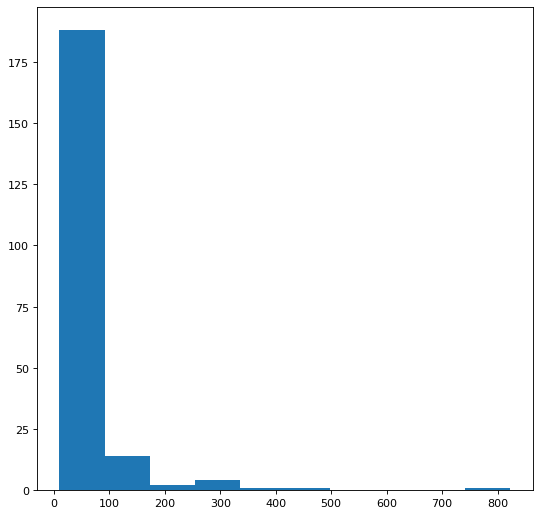

In [63]:
figure(figsize=(8, 8), dpi=80)
n_bins = 10
values = [speaker_times[id] for id in personalization_speakers if speaker_times[id] > 10]
plt.hist(values, n_bins)
#plt.xscale('log', nonposx='clip')
print(len(values))

> 100 Hours

21


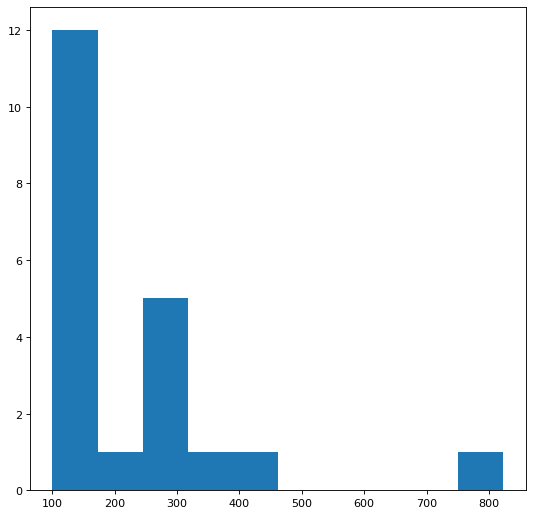

In [64]:
figure(figsize=(8, 8), dpi=80)
n_bins = 10
values = [speaker_times[id] for id in personalization_speakers if speaker_times[id] > 100]
plt.hist(values, n_bins)
#plt.xscale('log', nonposx='clip')
print(len(values))